## Instalación de librerias
---

In [1]:
!pip install diffusers invisible_watermark transformers accelerate safetensors opencv-python

## Carga de Librerías
---

In [ ]:
from diffusers import DiffusionPipeline
import torch

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## ¿Cómo funciona el pipeline de Stable Diffusion?

---



Stable Diffusion es un modelo de difusión latente de texto a imagen. Se denomina modelo de difusión latente porque trabaja con una representación de la imagen de menor dimensión en lugar del espacio de píxeles real, lo que lo hace más eficiente en términos de memoria. El codificador comprime la imagen en una representación más pequeña, y un decodificador para convertir la representación comprimida de nuevo en una imagen. Para los modelos de texto a imagen, necesitarás un tokenizador y un codificador para generar incrustaciones de texto.

El modelo Stable Diffusion está compuesto por 3 modelos:
1. **Variational Auto Encoder (VAE)**: Se trata de un modelo encoder-decoder, que aprende a convertir una imagen en ruido, y a partir de ese ruido, volver a generar la imagen. Partiendo del ruido, se encarga de transformar la imágen con ruido en la imagen que queremos.
2. **U-NET**: La U-Net tiene una parte codificadora y otra decodificadora, ambas compuestas por bloques ResNet. El codificador comprime una representación de imagen en una representación de imagen de menor resolución y el descodificador descodifica la representación de imagen de menor resolución de vuelta a la representación de imagen de mayor resolución original que supuestamente es menos ruidosa. El objetivo de esta parte es aprender a extraer el ruido necesario a eliminar en cada paso para que finalmente el VAE sea capaz de obtener la imagen final.
3. **Text Encoder**: El codificador de texto se encarga de transformar el texto de entrada (por ejemplo, «Un astronauta montando a caballo») en un espacio de incrustación comprensible para la U-Net. Suele tratarse de un codificador simple basado en transformadores que asigna una secuencia de tokens de entrada a una secuencia de incrustaciones de texto latentes.



Carga de modelos

In [3]:
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
repo_id = "CompVis/stable-diffusion-v1-4"

vae = AutoencoderKL.from_pretrained(repo_id, subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained(repo_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    repo_id, subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    repo_id, subfolder="unet", use_safetensors=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(repo_id, subfolder="scheduler")

Para acelerar la inferencia, traslada los modelos a una GPU, ya que, a diferencia del programador, tienen pesos entrenables.

In [5]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

El siguiente paso consiste en tokenizar el texto para generar incrustaciones. El texto se utiliza para condicionar el modelo UNet y dirigir el proceso de difusión hacia algo que se parezca a la solicitud de entrada.

In [6]:
prompt = ["a dog swimming on the beach"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device='cuda')  # Seed generator to create the initial latent noise
batch_size = len(prompt)

Tokenize the text and generate the embeddings from the prompt:

In [7]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

A continuación, genere un poco de ruido aleatorio inicial como punto de partida para el proceso de difusión. Esta es la representación latente de la imagen, que se irá desenotizando gradualmente. En este punto, la imagen latente es más pequeña que el tamaño final de la imagen, pero no pasa nada porque el modelo la transformará más tarde en la imagen final de 512x512.

In [8]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device='cuda',
)

Empezar por escalar la entrada con la distribución de ruido inicial, sigma, el valor de escala de ruido.

In [9]:
latents = latents * scheduler.init_noise_sigma

El último paso es crear el bucle de eliminación de ruido que transformará progresivamente el ruido puro de las latentes en una imagen descrita por la solicitud. Recuerde, el bucle de eliminación de ruido tiene que hacer tres cosas:

1. Establecer los pasos de tiempo del programador que se utilizarán durante la eliminación de ruido.
2. Iterar sobre los pasos de tiempo.
3. En cada paso de tiempo, llamar al modelo UNet para predecir el ruido residual y pasarlo al planificador para calcular la muestra ruidosa anterior.

In [10]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

## Decodificar la imagen
El último paso consiste en utilizar el vae para descodificar la representación latente en una imagen y obtener la salida descodificada con muestra:

In [11]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

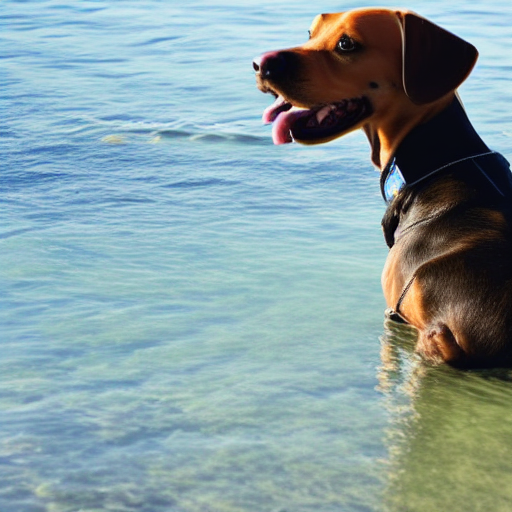

In [12]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

## Inferencia por Pipeline
---
Cargamos el modelo de HuggingFace *stable-diffusion-xl-base-1.0* y realizamos una inferencia.

In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Inferencia
---
Pasamos prompts al modelo para obtener imagenes a partir del texto introducido al modelo. Podemos obtener imagenes de distinta calidad jugando con los hiperparámetros del modelo. Para consultar los hiperparámetros lanzar ```help(pipe)```.

In [ ]:
prompt = "A red dog riding a bike"

images = pipe(prompt=prompt, height=512, width=512, num_inference_steps=25, num_images_per_prompt=2).images

  0%|          | 0/25 [00:00<?, ?it/s]

Image 0


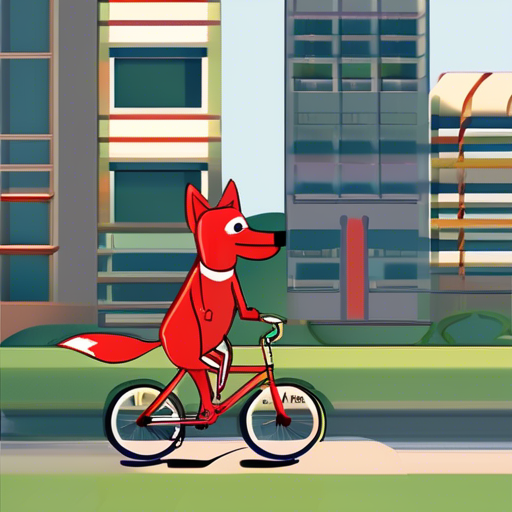

Image 1


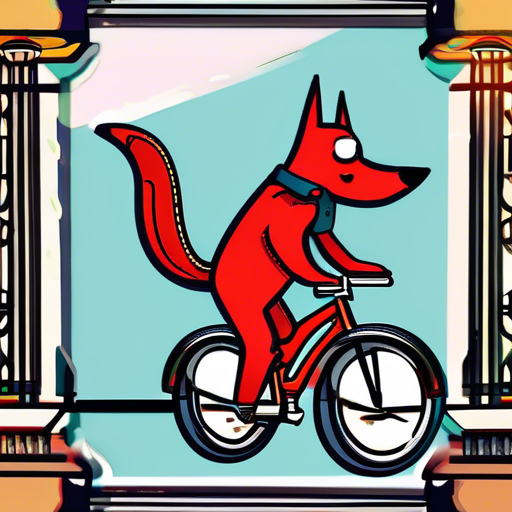

In [ ]:
from IPython.display import display
for i in range(len(images)):
  print(f'Image {str(i+1)}')
  display(images[i])
  print("====================================================")